# Control VAE

### Importing libraries 

In [1]:
!pip install pytorch-fid

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from PIL import Image
from pytorch_fid import fid_score

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms
from torchvision.utils import save_image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Setting up the GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Constants

In [4]:
NPZ_PATH = '/kaggle/input/dsprites-2d/sh3_sc6_y32_x32_imgs.npz'
TRAIN_RATIO = 0.9
BATCH_SIZE = 128
BETA_1 = 0.9
BETA_2 = 0.99
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
LATENT_DIM = 10
W_KL = 100
W_REC = 100
RANDOM_SEED = 18

## Data

In [5]:
class DspritesDataset(Dataset):

    def __init__(self, npz_path, transform=None):
        self.data = np.load(npz_path, allow_pickle=True, encoding='latin1')
        self.transform = transform
        self.images = self.data['imgs']

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0).float()),
])
raw_dataset = DspritesDataset(NPZ_PATH, transform=transform)
print(len(raw_dataset))

18432


In [7]:
train_size = int(TRAIN_RATIO * len(raw_dataset))
test_size = len(raw_dataset) - train_size
train_dataset, test_dataset = random_split(raw_dataset, [train_size, test_size])

In [8]:
print(f'Train size: {len(train_dataset)}')
print(f'Test size: {len(test_dataset)}')

print(train_dataset[0].shape)
print(train_dataset[0])
print()

for i in range(64):
    for j in range(64):
        print(int(train_dataset[0][0][i][j].item())*7, end=" ")
    print()

print()
print(train_dataset[0].min())
print(train_dataset[0].max())

Train size: 16588
Test size: 1844
torch.Size([1, 64, 64])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

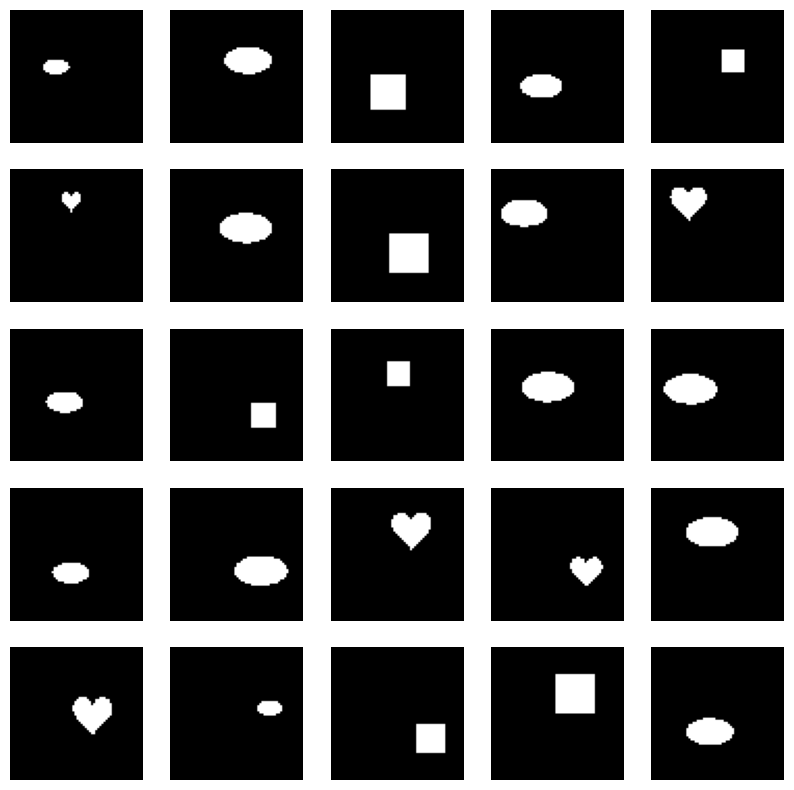

In [9]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_dataset[i][0], cmap='gray')
    plt.axis('off')

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

## VAE

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=4, stride=1),
            nn.ReLU(),
        )
        self.fc_encoder = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, 256)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
        )
        self.sigmoid = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)        
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(-1, 256)
        h = self.fc_encoder(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        h = self.fc_decoder(z)
        h = h.view(-1, 256, 1, 1)
        x = self.decoder(h)
        x = self.sigmoid(x)
        return x
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x = self.decode(z)
        return x, mu, logvar
    

In [12]:
def kl_divergence(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp())).sum(dim=1).mean()

In [13]:
def reconstruction_loss(x, x_hat):
    # x_hat = torch.sigmoid(x_hat)
    return F.mse_loss(x_hat, x, size_average=False)
    # return F.binary_cross_entropy_with_logits(x_hat, x, size_average=False)

In [14]:
def loss_function(x, x_hat, mu, logvar):
    return W_REC * reconstruction_loss(x, x_hat) + W_KL * kl_divergence(mu, logvar)

In [15]:
def train_VAE(model, optimizer, train_dataloader, test_dataloader, epochs):
    train_losses = []
    train_kl_losses = []
    train_recon_losses = []
    test_losses = []
    test_kl_losses = []
    test_recon_losses = []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        model.train()
        train_loss = 0
        train_kl_loss = 0
        train_recon_loss = 0
        for batch in tqdm.tqdm(train_dataloader):
            batch = batch.to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar = model(batch)
            loss = loss_function(batch, x_hat, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            with torch.no_grad():
                train_kl_loss += kl_divergence(mu, logvar).item()
                train_recon_loss += reconstruction_loss(batch, x_hat).item()
        train_loss /= len(train_dataloader.dataset)
        train_kl_loss /= len(train_dataloader.dataset)
        train_recon_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)
        train_kl_losses.append(train_kl_loss)
        train_recon_losses.append(train_recon_loss)
        print(f'Train loss: {train_loss:.4f}, KL loss: {train_kl_loss:.4f}, Reconstruciton loss: {train_recon_loss:.4f}')
        
        model.eval()
        test_loss = 0
        test_kl_loss = 0
        test_recon_loss = 0
        with torch.no_grad():
            for batch in tqdm.tqdm(test_dataloader):
                batch = batch.to(device)
                x_hat, mu, logvar = model(batch)                
                loss = loss_function(batch, x_hat, mu, logvar)
                test_loss += loss.item()
                with torch.no_grad():
                    test_kl_loss += kl_divergence(mu, logvar).item()
                    test_recon_loss += reconstruction_loss(batch, x_hat).item()
        test_loss /= len(test_dataloader.dataset)
        test_kl_loss /= len(test_dataloader.dataset)
        test_recon_loss /= len(test_dataloader.dataset)
        test_losses.append(test_loss)
        test_kl_losses.append(test_kl_loss)
        test_recon_losses.append(test_recon_loss)
        print(f'Test loss: {test_loss:.4f}, KL loss: {test_kl_loss:.4f}, Reconstruciton loss: {test_recon_loss:.4f}')
    return train_losses, train_kl_losses, train_recon_losses, test_losses, test_kl_losses, test_recon_losses

In [16]:
def plot_losses(title, losses, kl_losses, recon_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Total loss')
    plt.plot([loss * W_KL for loss in kl_losses], label='KL loss')
    plt.plot([loss * W_REC for loss in recon_losses], label='Reconstruction loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [17]:
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))
train_losses, train_kl_losses, train_recon_losses, test_losses, test_kl_losses, test_recon_losses = train_VAE(model, optimizer, train_dataloader, test_dataloader, epochs=NUM_EPOCHS)


Epoch 1/50


  0%|          | 0/129 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 129/129 [00:05<00:00, 22.00it/s]


Train loss: 22350.4897, KL loss: 2.0154, Reconstruciton loss: 221.4895


100%|██████████| 14/14 [00:00<00:00, 49.49it/s]


Test loss: 17156.0205, KL loss: 0.1422, Reconstruciton loss: 171.4180
Epoch 2/50


100%|██████████| 129/129 [00:03<00:00, 38.64it/s]


Train loss: 17335.6571, KL loss: 0.0895, Reconstruciton loss: 173.2671


100%|██████████| 14/14 [00:00<00:00, 51.31it/s]


Test loss: 17143.1453, KL loss: 0.0476, Reconstruciton loss: 171.3838
Epoch 3/50


100%|██████████| 129/129 [00:03<00:00, 39.16it/s]


Train loss: 17337.7390, KL loss: 0.0375, Reconstruciton loss: 173.3399


100%|██████████| 14/14 [00:00<00:00, 51.18it/s]


Test loss: 17140.5231, KL loss: 0.0292, Reconstruciton loss: 171.3761
Epoch 4/50


100%|██████████| 129/129 [00:03<00:00, 38.91it/s]


Train loss: 17335.8692, KL loss: 0.0276, Reconstruciton loss: 173.3311


100%|██████████| 14/14 [00:00<00:00, 51.46it/s]


Test loss: 17139.7865, KL loss: 0.0259, Reconstruciton loss: 171.3719
Epoch 5/50


100%|██████████| 129/129 [00:03<00:00, 38.38it/s]


Train loss: 17324.6351, KL loss: 0.0188, Reconstruciton loss: 173.2275


100%|██████████| 14/14 [00:00<00:00, 53.02it/s]


Test loss: 17139.1396, KL loss: 0.0155, Reconstruciton loss: 171.3759
Epoch 6/50


100%|██████████| 129/129 [00:03<00:00, 38.91it/s]


Train loss: 17322.2219, KL loss: 0.0123, Reconstruciton loss: 173.2100


100%|██████████| 14/14 [00:00<00:00, 50.50it/s]


Test loss: 17138.0485, KL loss: 0.0088, Reconstruciton loss: 171.3717
Epoch 7/50


100%|██████████| 129/129 [00:03<00:00, 38.96it/s]


Train loss: 17331.4999, KL loss: 0.0061, Reconstruciton loss: 173.3089


100%|██████████| 14/14 [00:00<00:00, 53.46it/s]


Test loss: 17137.4289, KL loss: 0.0032, Reconstruciton loss: 171.3711
Epoch 8/50


100%|██████████| 129/129 [00:03<00:00, 38.86it/s]


Train loss: 17332.8895, KL loss: 0.0022, Reconstruciton loss: 173.3267


100%|██████████| 14/14 [00:00<00:00, 52.34it/s]


Test loss: 17137.1967, KL loss: 0.0010, Reconstruciton loss: 171.3709
Epoch 9/50


100%|██████████| 129/129 [00:03<00:00, 38.73it/s]


Train loss: 17324.6376, KL loss: 0.0005, Reconstruciton loss: 173.2459


100%|██████████| 14/14 [00:00<00:00, 49.87it/s]


Test loss: 17137.0583, KL loss: 0.0001, Reconstruciton loss: 171.3705
Epoch 10/50


100%|██████████| 129/129 [00:03<00:00, 37.89it/s]


Train loss: 17331.9925, KL loss: 0.0000, Reconstruciton loss: 173.3199


100%|██████████| 14/14 [00:00<00:00, 52.05it/s]


Test loss: 17137.0392, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 11/50


100%|██████████| 129/129 [00:03<00:00, 38.71it/s]


Train loss: 17322.9506, KL loss: 0.0000, Reconstruciton loss: 173.2295


100%|██████████| 14/14 [00:00<00:00, 52.25it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 12/50


100%|██████████| 129/129 [00:03<00:00, 38.63it/s]


Train loss: 17330.9320, KL loss: 0.0000, Reconstruciton loss: 173.3093


100%|██████████| 14/14 [00:00<00:00, 51.70it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 13/50


100%|██████████| 129/129 [00:03<00:00, 38.74it/s]


Train loss: 17330.0157, KL loss: 0.0000, Reconstruciton loss: 173.3002


100%|██████████| 14/14 [00:00<00:00, 54.04it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 14/50


100%|██████████| 129/129 [00:03<00:00, 39.04it/s]


Train loss: 17330.9019, KL loss: 0.0000, Reconstruciton loss: 173.3090


100%|██████████| 14/14 [00:00<00:00, 53.23it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 15/50


100%|██████████| 129/129 [00:03<00:00, 39.07it/s]


Train loss: 17330.1242, KL loss: 0.0000, Reconstruciton loss: 173.3012


100%|██████████| 14/14 [00:00<00:00, 53.44it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 16/50


100%|██████████| 129/129 [00:03<00:00, 38.81it/s]


Train loss: 17330.7752, KL loss: 0.0000, Reconstruciton loss: 173.3078


100%|██████████| 14/14 [00:00<00:00, 53.08it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 17/50


100%|██████████| 129/129 [00:03<00:00, 39.15it/s]


Train loss: 11263.1278, KL loss: 0.3447, Reconstruciton loss: 112.2866


100%|██████████| 14/14 [00:00<00:00, 53.83it/s]


Test loss: 3838.7727, KL loss: 1.0363, Reconstruciton loss: 37.3515
Epoch 18/50


100%|██████████| 129/129 [00:03<00:00, 37.94it/s]


Train loss: 2948.7126, KL loss: 0.6948, Reconstruciton loss: 28.7923


100%|██████████| 14/14 [00:00<00:00, 53.17it/s]


Test loss: 2481.6127, KL loss: 0.5953, Reconstruciton loss: 24.2209
Epoch 19/50


100%|██████████| 129/129 [00:03<00:00, 38.76it/s]


Train loss: 2435.5938, KL loss: 0.5624, Reconstruciton loss: 23.7936


100%|██████████| 14/14 [00:00<00:00, 52.16it/s]


Test loss: 2097.9196, KL loss: 0.5339, Reconstruciton loss: 20.4453
Epoch 20/50


100%|██████████| 129/129 [00:03<00:00, 38.51it/s]


Train loss: 1899.1752, KL loss: 0.5615, Reconstruciton loss: 18.4302


100%|██████████| 14/14 [00:00<00:00, 53.18it/s]


Test loss: 1687.0481, KL loss: 0.5437, Reconstruciton loss: 16.3267
Epoch 21/50


100%|██████████| 129/129 [00:03<00:00, 38.96it/s]


Train loss: 1528.7183, KL loss: 0.5968, Reconstruciton loss: 14.6904


100%|██████████| 14/14 [00:00<00:00, 52.68it/s]


Test loss: 1464.9529, KL loss: 0.5751, Reconstruciton loss: 14.0744
Epoch 22/50


100%|██████████| 129/129 [00:03<00:00, 39.37it/s]


Train loss: 1359.1794, KL loss: 0.5950, Reconstruciton loss: 12.9968


100%|██████████| 14/14 [00:00<00:00, 54.28it/s]


Test loss: 1257.5720, KL loss: 0.5844, Reconstruciton loss: 11.9914
Epoch 23/50


100%|██████████| 129/129 [00:03<00:00, 38.68it/s]


Train loss: 1226.9692, KL loss: 0.5946, Reconstruciton loss: 11.6751


100%|██████████| 14/14 [00:00<00:00, 52.01it/s]


Test loss: 1101.4220, KL loss: 0.6208, Reconstruciton loss: 10.3935
Epoch 24/50


100%|██████████| 129/129 [00:03<00:00, 38.45it/s]


Train loss: 1134.6072, KL loss: 0.5941, Reconstruciton loss: 10.7520


100%|██████████| 14/14 [00:00<00:00, 51.31it/s]


Test loss: 1108.1321, KL loss: 0.5906, Reconstruciton loss: 10.4907
Epoch 25/50


100%|██████████| 129/129 [00:03<00:00, 38.84it/s]


Train loss: 1006.2734, KL loss: 0.5975, Reconstruciton loss: 9.4652


100%|██████████| 14/14 [00:00<00:00, 52.80it/s]


Test loss: 991.0898, KL loss: 0.5762, Reconstruciton loss: 9.3347
Epoch 26/50


100%|██████████| 129/129 [00:03<00:00, 39.00it/s]


Train loss: 1015.5362, KL loss: 0.5690, Reconstruciton loss: 9.5864


100%|██████████| 14/14 [00:00<00:00, 47.79it/s]


Test loss: 849.1794, KL loss: 0.5772, Reconstruciton loss: 7.9146
Epoch 27/50


100%|██████████| 129/129 [00:03<00:00, 37.99it/s]


Train loss: 905.8312, KL loss: 0.5790, Reconstruciton loss: 8.4793


100%|██████████| 14/14 [00:00<00:00, 52.36it/s]


Test loss: 866.1776, KL loss: 0.5838, Reconstruciton loss: 8.0780
Epoch 28/50


100%|██████████| 129/129 [00:03<00:00, 38.44it/s]


Train loss: 898.6728, KL loss: 0.5644, Reconstruciton loss: 8.4223


100%|██████████| 14/14 [00:00<00:00, 52.36it/s]


Test loss: 790.6287, KL loss: 0.5690, Reconstruciton loss: 7.3373
Epoch 29/50


100%|██████████| 129/129 [00:03<00:00, 38.42it/s]


Train loss: 795.5987, KL loss: 0.5748, Reconstruciton loss: 7.3812


100%|██████████| 14/14 [00:00<00:00, 53.22it/s]


Test loss: 806.6040, KL loss: 0.5684, Reconstruciton loss: 7.4976
Epoch 30/50


100%|██████████| 129/129 [00:03<00:00, 38.62it/s]


Train loss: 812.0744, KL loss: 0.5573, Reconstruciton loss: 7.5635


100%|██████████| 14/14 [00:00<00:00, 53.70it/s]


Test loss: 744.9193, KL loss: 0.5225, Reconstruciton loss: 6.9267
Epoch 31/50


100%|██████████| 129/129 [00:03<00:00, 38.52it/s]


Train loss: 763.7716, KL loss: 0.5518, Reconstruciton loss: 7.0859


100%|██████████| 14/14 [00:00<00:00, 51.59it/s]


Test loss: 759.4659, KL loss: 0.5321, Reconstruciton loss: 7.0626
Epoch 32/50


100%|██████████| 129/129 [00:03<00:00, 38.54it/s]


Train loss: 742.9511, KL loss: 0.5438, Reconstruciton loss: 6.8858


100%|██████████| 14/14 [00:00<00:00, 53.91it/s]


Test loss: 648.1777, KL loss: 0.5459, Reconstruciton loss: 5.9358
Epoch 33/50


100%|██████████| 129/129 [00:03<00:00, 38.53it/s]


Train loss: 712.6455, KL loss: 0.5404, Reconstruciton loss: 6.5861


100%|██████████| 14/14 [00:00<00:00, 51.36it/s]


Test loss: 664.1154, KL loss: 0.5121, Reconstruciton loss: 6.1290
Epoch 34/50


100%|██████████| 129/129 [00:03<00:00, 39.14it/s]


Train loss: 704.7821, KL loss: 0.5305, Reconstruciton loss: 6.5173


100%|██████████| 14/14 [00:00<00:00, 52.90it/s]


Test loss: 810.6741, KL loss: 0.5044, Reconstruciton loss: 7.6024
Epoch 35/50


100%|██████████| 129/129 [00:03<00:00, 37.93it/s]


Train loss: 680.8010, KL loss: 0.5261, Reconstruciton loss: 6.2820


100%|██████████| 14/14 [00:00<00:00, 48.73it/s]


Test loss: 688.2194, KL loss: 0.5343, Reconstruciton loss: 6.3479
Epoch 36/50


100%|██████████| 129/129 [00:03<00:00, 38.93it/s]


Train loss: 672.5289, KL loss: 0.5160, Reconstruciton loss: 6.2093


100%|██████████| 14/14 [00:00<00:00, 52.94it/s]


Test loss: 660.5008, KL loss: 0.4932, Reconstruciton loss: 6.1118
Epoch 37/50


100%|██████████| 129/129 [00:03<00:00, 38.95it/s]


Train loss: 650.0561, KL loss: 0.5147, Reconstruciton loss: 5.9858


100%|██████████| 14/14 [00:00<00:00, 49.14it/s]


Test loss: 570.8687, KL loss: 0.5181, Reconstruciton loss: 5.1906
Epoch 38/50


100%|██████████| 129/129 [00:03<00:00, 38.97it/s]


Train loss: 622.2590, KL loss: 0.5146, Reconstruciton loss: 5.7080


100%|██████████| 14/14 [00:00<00:00, 53.69it/s]


Test loss: 625.5579, KL loss: 0.5072, Reconstruciton loss: 5.7484
Epoch 39/50


100%|██████████| 129/129 [00:03<00:00, 39.18it/s]


Train loss: 647.8324, KL loss: 0.5013, Reconstruciton loss: 5.9770


100%|██████████| 14/14 [00:00<00:00, 51.56it/s]


Test loss: 610.3270, KL loss: 0.4921, Reconstruciton loss: 5.6112
Epoch 40/50


100%|██████████| 129/129 [00:03<00:00, 38.80it/s]


Train loss: 615.8968, KL loss: 0.5044, Reconstruciton loss: 5.6545


100%|██████████| 14/14 [00:00<00:00, 52.33it/s]


Test loss: 645.9932, KL loss: 0.4978, Reconstruciton loss: 5.9621
Epoch 41/50


100%|██████████| 129/129 [00:03<00:00, 38.46it/s]


Train loss: 606.7670, KL loss: 0.4987, Reconstruciton loss: 5.5690


100%|██████████| 14/14 [00:00<00:00, 54.23it/s]


Test loss: 643.3233, KL loss: 0.5025, Reconstruciton loss: 5.9308
Epoch 42/50


100%|██████████| 129/129 [00:03<00:00, 39.10it/s]


Train loss: 610.2344, KL loss: 0.4980, Reconstruciton loss: 5.6044


100%|██████████| 14/14 [00:00<00:00, 54.49it/s]


Test loss: 575.6593, KL loss: 0.4781, Reconstruciton loss: 5.2785
Epoch 43/50


100%|██████████| 129/129 [00:03<00:00, 38.90it/s]


Train loss: 560.1564, KL loss: 0.4970, Reconstruciton loss: 5.1046


100%|██████████| 14/14 [00:00<00:00, 52.30it/s]


Test loss: 516.2830, KL loss: 0.4931, Reconstruciton loss: 4.6697
Epoch 44/50


100%|██████████| 129/129 [00:03<00:00, 37.91it/s]


Train loss: 603.7924, KL loss: 0.4920, Reconstruciton loss: 5.5459


100%|██████████| 14/14 [00:00<00:00, 52.53it/s]


Test loss: 734.0187, KL loss: 0.4692, Reconstruciton loss: 6.8709
Epoch 45/50


100%|██████████| 129/129 [00:03<00:00, 38.57it/s]


Train loss: 516.0372, KL loss: 0.4940, Reconstruciton loss: 4.6664


100%|██████████| 14/14 [00:00<00:00, 54.57it/s]


Test loss: 493.6468, KL loss: 0.4812, Reconstruciton loss: 4.4552
Epoch 46/50


100%|██████████| 129/129 [00:03<00:00, 38.69it/s]


Train loss: 588.8149, KL loss: 0.4821, Reconstruciton loss: 5.4060


100%|██████████| 14/14 [00:00<00:00, 52.19it/s]


Test loss: 456.2495, KL loss: 0.4828, Reconstruciton loss: 4.0797
Epoch 47/50


100%|██████████| 129/129 [00:03<00:00, 38.75it/s]


Train loss: 564.5301, KL loss: 0.4827, Reconstruciton loss: 5.1626


100%|██████████| 14/14 [00:00<00:00, 51.83it/s]


Test loss: 485.3399, KL loss: 0.4709, Reconstruciton loss: 4.3825
Epoch 48/50


100%|██████████| 129/129 [00:03<00:00, 38.77it/s]


Train loss: 484.0498, KL loss: 0.4906, Reconstruciton loss: 4.3499


100%|██████████| 14/14 [00:00<00:00, 53.69it/s]


Test loss: 484.5593, KL loss: 0.4723, Reconstruciton loss: 4.3733
Epoch 49/50


100%|██████████| 129/129 [00:03<00:00, 38.61it/s]


Train loss: 547.8078, KL loss: 0.4759, Reconstruciton loss: 5.0022


100%|██████████| 14/14 [00:00<00:00, 53.94it/s]


Test loss: 453.8158, KL loss: 0.4773, Reconstruciton loss: 4.0608
Epoch 50/50


100%|██████████| 129/129 [00:03<00:00, 38.75it/s]


Train loss: 522.7684, KL loss: 0.4831, Reconstruciton loss: 4.7446


100%|██████████| 14/14 [00:00<00:00, 54.31it/s]

Test loss: 548.0447, KL loss: 0.4584, Reconstruciton loss: 5.0221


### Evaluation

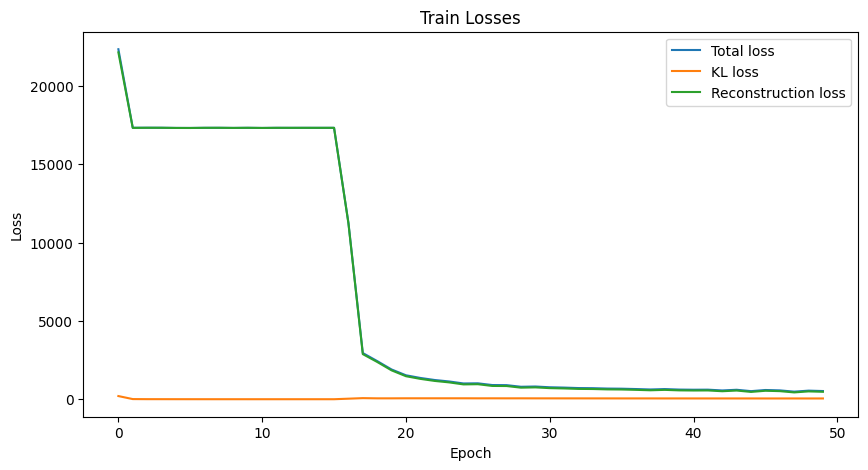

In [18]:
plot_losses('Train Losses', train_losses, train_kl_losses, train_recon_losses)

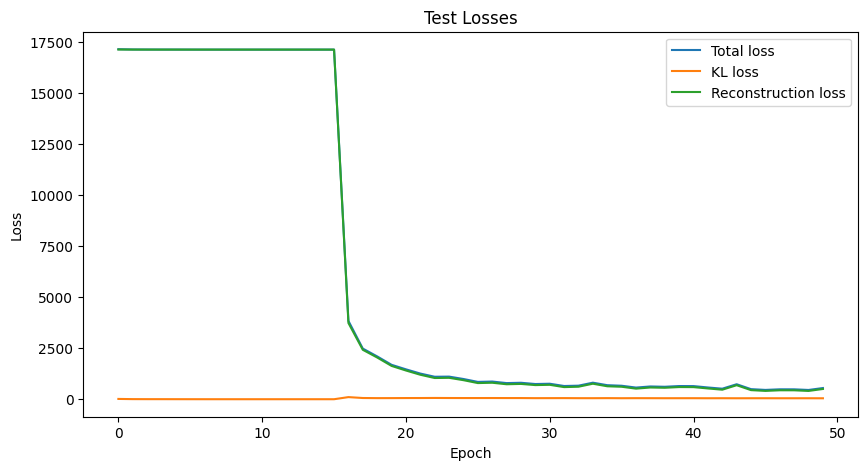

In [19]:
plot_losses('Test Losses', test_losses, test_kl_losses, test_recon_losses)

In [20]:
def plot_reconstructions(model, test_dataloader, n=5):
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            batch = batch.to(device)
            x_hat, _, _ = model(batch)
            # x_hat = torch.sigmoid(x_hat)
            # print(x_hat)
            x_hat = torch.round(x_hat)
            break
    
    print(torch.min(x_hat))
    print(torch.max(x_hat))
    print(torch.min(batch[0]))
    print(torch.max(batch[0]))
    
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(batch[i][0].cpu(), cmap='gray')
        plt.axis('off')
        plt.subplot(2, n, i+1+n)
        plt.imshow(x_hat[i][0].cpu(), cmap='gray')
        plt.axis('off')
    plt.show()

tensor(0., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(1., device='cuda:0')


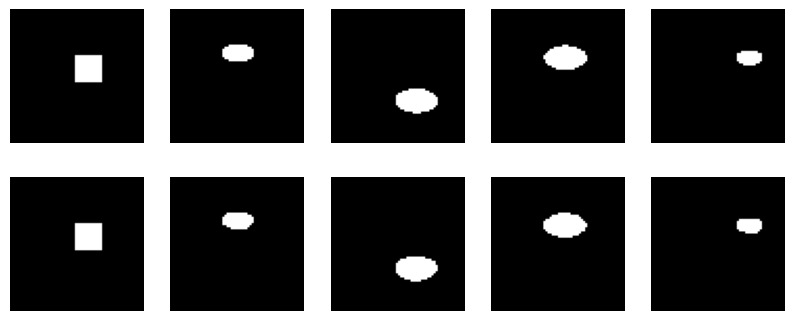

In [21]:
plot_reconstructions(model, test_dataloader)

In [22]:
def plot_generated(model, n=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n*n, model.latent_dim).to(device)
        x_hat = model.decode(z)
        # x_hat = torch.sigmoid(x_hat)
        x_hat = torch.round(x_hat)
    
    print(torch.min(x_hat))
    print(torch.max(x_hat))
    
    plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_hat[i][0].cpu(), cmap='gray')
        plt.axis('off')
    plt.show()


tensor(0., device='cuda:0')
tensor(1., device='cuda:0')


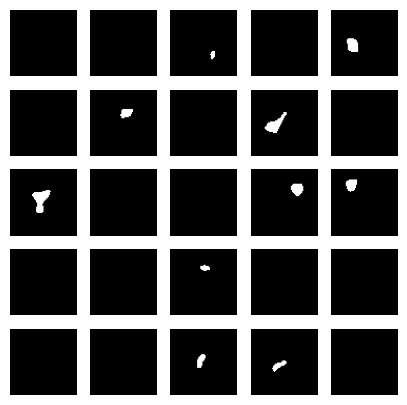

In [23]:
plot_generated(model)

#### FID-Score

In [24]:
num_train_samples = 3500
num_test_samples = 1500

train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

fid_train_dataloader = DataLoader(train_dataset, batch_size=1, sampler=train_sampler)
fid_test_dataloader = DataLoader(test_dataset, batch_size=1, sampler=test_sampler)

ORIGINAL_DIR = 'original_samples'
GENERATED_DIR = 'generated_samples'

os.makedirs(ORIGINAL_DIR, exist_ok=True)
os.makedirs(GENERATED_DIR, exist_ok=True)

model.eval()
with torch.no_grad():
    for i, batch in enumerate(fid_train_dataloader):
        image = batch[0][0]
        image = image * 255
        image = image.byte()
        image = transforms.ToPILImage()(image)
        image.save(os.path.join(ORIGINAL_DIR, f'train_{i}.png'))

        batch = batch.to(device)
        x_hat, _, _ = model(batch)
        x_hat = torch.round(x_hat)
        image = x_hat[0][0]
        image = image * 255
        image = image.byte()
        image = transforms.ToPILImage()(image)
        image.save(os.path.join(GENERATED_DIR, f'train_{i}.png'))

    for i, batch in enumerate(fid_test_dataloader):
        image = batch[0][0]
        image = image * 255
        image = image.byte()
        image = transforms.ToPILImage()(image)
        image.save(os.path.join(ORIGINAL_DIR, f'test_{i}.png'))

        batch = batch.to(device)
        x_hat, _, _ = model(batch)
        x_hat = torch.round(x_hat)
        image = x_hat[0][0]
        image = image * 255
        image = image.byte()
        image = transforms.ToPILImage()(image)
        image.save(os.path.join(GENERATED_DIR, f'test_{i}.png'))


In [25]:
VAE_fid_score = fid_score.calculate_fid_given_paths([ORIGINAL_DIR, GENERATED_DIR], batch_size=50, device=device, dims=2048)
print(VAE_fid_score)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 261MB/s] 
100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


8.308855418986354


## Control VAE

In [26]:
class PIController:
    def __init__(self, setpoint, Kp=0.01, Ki=0.001, beta_min=0.0, beta_max=1.0):
        self.Kp = Kp
        self.Ki = Ki
        self.setpoint = setpoint
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.cur_Ik = 0.0
        self.cur_Wk = 0.0

    def step(self, error):
        error_k = self.setpoint - error
        Pk = self.Kp * (1.0 / (1.0 + np.exp(error_k)))
        
        Ik = self.cur_Ik
        if self.beta_min <= self.cur_Wk <= self.beta_max:
            Ik -= self.Ki * error_k

        Wk = Pk + Ik
        self.cur_Wk = Wk
        self.cur_Ik = Ik

        Wk = np.clip(Wk, self.beta_min, self.beta_max)
        return Wk
    

In [27]:
def train_CVAE(model, optimizer, train_dataloader, test_dataloader, epochs, setpoint):
    train_losses = []
    train_kl_losses = []
    train_recon_losses = []
    test_losses = []
    test_kl_losses = []
    test_recon_losses = []
    PI_controller = PIController(setpoint)
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        model.train()
        train_loss = 0
        train_kl_loss = 0
        train_recon_loss = 0
        for batch in tqdm.tqdm(train_dataloader):
            batch = batch.to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar = model(batch)
            loss = loss_function(batch, x_hat, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            with torch.no_grad():
                train_kl_loss += kl_divergence(mu, logvar).item()
                train_recon_loss += reconstruction_loss(batch, x_hat).item()
        train_loss /= len(train_dataloader.dataset)
        train_kl_loss /= len(train_dataloader.dataset)
        train_recon_loss /= len(train_dataloader.dataset)
        W_KL = PI_controller.step(error=train_kl_loss)
        train_losses.append(train_loss)
        train_kl_loss *= W_KL
        train_kl_losses.append(train_kl_loss)
        train_recon_losses.append(train_recon_loss)
        print(f'Train loss: {train_loss:.4f}, KL loss: {train_kl_loss:.4f}, Reconstruciton loss: {train_recon_loss:.4f}')
        
        model.eval()
        test_loss = 0
        test_kl_loss = 0
        test_recon_loss = 0
        with torch.no_grad():
            for batch in tqdm.tqdm(test_dataloader):
                batch = batch.to(device)
                x_hat, mu, logvar = model(batch)                
                loss = loss_function(batch, x_hat, mu, logvar)
                test_loss += loss.item()
                with torch.no_grad():
                    test_kl_loss += kl_divergence(mu, logvar).item()
                    test_recon_loss += reconstruction_loss(batch, x_hat).item()
        test_loss /= len(test_dataloader.dataset)
        test_kl_loss /= len(test_dataloader.dataset)
        test_recon_loss /= len(test_dataloader.dataset)
        test_losses.append(test_loss)
        test_kl_losses.append(test_kl_loss)
        test_recon_losses.append(test_recon_loss)
        print(f'Test loss: {test_loss:.4f}, KL loss: {test_kl_loss:.4f}, Reconstruciton loss: {test_recon_loss:.4f}')
    return train_losses, train_kl_losses, train_recon_losses, test_losses, test_kl_losses, test_recon_losses

In [28]:
def plot_losses_with_setpoint(title, setpoint_1, setpoint_2, losses_for_setpoint1, losses_for_setpoint2):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_for_setpoint1, label=f'loss with setpoint {setpoint_1}')
    plt.plot(losses_for_setpoint2, label=f'loss with setpoint {setpoint_2}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [29]:
control_model_8 = VAE(latent_dim=LATENT_DIM).to(device)
control_optimizer_8 = optim.Adam(control_model_8.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))
control_train_losses_8, control_train_kl_losses_8, control_train_recon_losses_8, control_test_losses_8, control_test_kl_losses_8, control_test_recon_losses_8 = train_CVAE(control_model_8, control_optimizer_8, train_dataloader, test_dataloader, epochs=NUM_EPOCHS, setpoint=8.0/BATCH_SIZE)


Epoch 1/50


100%|██████████| 129/129 [00:03<00:00, 37.81it/s]


Train loss: 35759.1563, KL loss: 18.0684, Reconstruciton loss: 228.0497


100%|██████████| 14/14 [00:00<00:00, 53.54it/s]


Test loss: 17146.1562, KL loss: 0.0676, Reconstruciton loss: 171.3940
Epoch 2/50


100%|██████████| 129/129 [00:03<00:00, 38.12it/s]


Train loss: 17339.3659, KL loss: 0.0070, Reconstruciton loss: 173.3414


100%|██████████| 14/14 [00:00<00:00, 51.37it/s]


Test loss: 17143.0937, KL loss: 0.0416, Reconstruciton loss: 171.3894
Epoch 3/50


100%|██████████| 129/129 [00:03<00:00, 37.59it/s]


Train loss: 17333.4940, KL loss: 0.0047, Reconstruciton loss: 173.3002


100%|██████████| 14/14 [00:00<00:00, 51.95it/s]


Test loss: 17140.3227, KL loss: 0.0284, Reconstruciton loss: 171.3749
Epoch 4/50


100%|██████████| 129/129 [00:03<00:00, 38.88it/s]


Train loss: 17323.7143, KL loss: 0.0031, Reconstruciton loss: 173.2142


100%|██████████| 14/14 [00:00<00:00, 52.50it/s]


Test loss: 17139.2018, KL loss: 0.0155, Reconstruciton loss: 171.3765
Epoch 5/50


100%|██████████| 129/129 [00:03<00:00, 38.65it/s]


Train loss: 17327.8199, KL loss: 0.0022, Reconstruciton loss: 173.2621


100%|██████████| 14/14 [00:00<00:00, 53.11it/s]


Test loss: 17138.5354, KL loss: 0.0101, Reconstruciton loss: 171.3753
Epoch 6/50


100%|██████████| 129/129 [00:03<00:00, 37.17it/s]


Train loss: 17324.3375, KL loss: 0.0013, Reconstruciton loss: 173.2339


100%|██████████| 14/14 [00:00<00:00, 40.25it/s]


Test loss: 17137.8951, KL loss: 0.0061, Reconstruciton loss: 171.3729
Epoch 7/50


100%|██████████| 129/129 [00:03<00:00, 37.56it/s]


Train loss: 17325.9973, KL loss: 0.0005, Reconstruciton loss: 173.2561


100%|██████████| 14/14 [00:00<00:00, 42.60it/s]


Test loss: 17137.2333, KL loss: 0.0013, Reconstruciton loss: 171.3710
Epoch 8/50


100%|██████████| 129/129 [00:03<00:00, 38.56it/s]


Train loss: 17327.3314, KL loss: 0.0001, Reconstruciton loss: 173.2727


100%|██████████| 14/14 [00:00<00:00, 51.71it/s]


Test loss: 17137.0643, KL loss: 0.0002, Reconstruciton loss: 171.3705
Epoch 9/50


100%|██████████| 129/129 [00:03<00:00, 38.70it/s]


Train loss: 17322.3767, KL loss: 0.0000, Reconstruciton loss: 173.2237


100%|██████████| 14/14 [00:00<00:00, 49.27it/s]


Test loss: 17137.0418, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 10/50


100%|██████████| 129/129 [00:03<00:00, 38.33it/s]


Train loss: 17320.0161, KL loss: 0.0000, Reconstruciton loss: 173.2002


100%|██████████| 14/14 [00:00<00:00, 51.74it/s]


Test loss: 17137.0395, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 11/50


100%|██████████| 129/129 [00:03<00:00, 37.88it/s]


Train loss: 17329.7688, KL loss: 0.0000, Reconstruciton loss: 173.2977


100%|██████████| 14/14 [00:00<00:00, 53.99it/s]


Test loss: 17137.0399, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 12/50


100%|██████████| 129/129 [00:03<00:00, 37.68it/s]


Train loss: 17327.0378, KL loss: 0.0000, Reconstruciton loss: 173.2704


100%|██████████| 14/14 [00:00<00:00, 52.74it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 13/50


100%|██████████| 129/129 [00:03<00:00, 37.81it/s]


Train loss: 17323.6135, KL loss: 0.0000, Reconstruciton loss: 173.2361


100%|██████████| 14/14 [00:00<00:00, 54.51it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 14/50


100%|██████████| 129/129 [00:03<00:00, 38.72it/s]


Train loss: 17321.8110, KL loss: 0.0000, Reconstruciton loss: 173.2181


100%|██████████| 14/14 [00:00<00:00, 50.98it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 15/50


100%|██████████| 129/129 [00:03<00:00, 38.22it/s]


Train loss: 17329.2441, KL loss: 0.0000, Reconstruciton loss: 173.2924


100%|██████████| 14/14 [00:00<00:00, 50.84it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 16/50


100%|██████████| 129/129 [00:03<00:00, 38.38it/s]


Train loss: 17332.6200, KL loss: 0.0000, Reconstruciton loss: 173.3262


100%|██████████| 14/14 [00:00<00:00, 53.27it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 17/50


100%|██████████| 129/129 [00:03<00:00, 38.63it/s]


Train loss: 17323.1131, KL loss: 0.0000, Reconstruciton loss: 173.2311


100%|██████████| 14/14 [00:00<00:00, 52.12it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 18/50


100%|██████████| 129/129 [00:03<00:00, 38.33it/s]


Train loss: 17324.1078, KL loss: 0.0000, Reconstruciton loss: 173.2411


100%|██████████| 14/14 [00:00<00:00, 50.52it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 19/50


100%|██████████| 129/129 [00:03<00:00, 38.76it/s]


Train loss: 17323.4205, KL loss: 0.0000, Reconstruciton loss: 173.2342


100%|██████████| 14/14 [00:00<00:00, 53.51it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 20/50


100%|██████████| 129/129 [00:03<00:00, 37.80it/s]


Train loss: 17328.5568, KL loss: 0.0000, Reconstruciton loss: 173.2856


100%|██████████| 14/14 [00:00<00:00, 52.10it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 21/50


100%|██████████| 129/129 [00:03<00:00, 38.49it/s]


Train loss: 17321.0875, KL loss: 0.0000, Reconstruciton loss: 173.2109


100%|██████████| 14/14 [00:00<00:00, 54.40it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 22/50


100%|██████████| 129/129 [00:03<00:00, 38.99it/s]


Train loss: 17326.7724, KL loss: 0.0000, Reconstruciton loss: 173.2677


100%|██████████| 14/14 [00:00<00:00, 53.99it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 23/50


100%|██████████| 129/129 [00:03<00:00, 38.71it/s]


Train loss: 17328.4181, KL loss: 0.0000, Reconstruciton loss: 173.2842


100%|██████████| 14/14 [00:00<00:00, 52.13it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 24/50


100%|██████████| 129/129 [00:03<00:00, 38.16it/s]


Train loss: 17321.6000, KL loss: 0.0000, Reconstruciton loss: 173.2160


100%|██████████| 14/14 [00:00<00:00, 52.84it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 25/50


100%|██████████| 129/129 [00:03<00:00, 38.47it/s]


Train loss: 17323.3603, KL loss: 0.0000, Reconstruciton loss: 173.2336


100%|██████████| 14/14 [00:00<00:00, 52.36it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 26/50


100%|██████████| 129/129 [00:03<00:00, 38.48it/s]


Train loss: 17320.2616, KL loss: 0.0000, Reconstruciton loss: 173.2026


100%|██████████| 14/14 [00:00<00:00, 53.17it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 27/50


100%|██████████| 129/129 [00:03<00:00, 38.27it/s]


Train loss: 17331.1249, KL loss: 0.0000, Reconstruciton loss: 173.3112


100%|██████████| 14/14 [00:00<00:00, 52.24it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 28/50


100%|██████████| 129/129 [00:03<00:00, 38.71it/s]


Train loss: 17324.9156, KL loss: 0.0000, Reconstruciton loss: 173.2492


100%|██████████| 14/14 [00:00<00:00, 54.18it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 29/50


100%|██████████| 129/129 [00:03<00:00, 37.89it/s]


Train loss: 17329.0180, KL loss: 0.0000, Reconstruciton loss: 173.2902


100%|██████████| 14/14 [00:00<00:00, 46.93it/s]


Test loss: 17136.5441, KL loss: 0.0001, Reconstruciton loss: 171.3654
Epoch 30/50


100%|██████████| 129/129 [00:03<00:00, 39.17it/s]


Train loss: 7274.0271, KL loss: 0.0501, Reconstruciton loss: 72.3660


100%|██████████| 14/14 [00:00<00:00, 51.77it/s]


Test loss: 2662.4718, KL loss: 0.4802, Reconstruciton loss: 26.1445
Epoch 31/50


100%|██████████| 129/129 [00:03<00:00, 38.74it/s]


Train loss: 2284.9235, KL loss: 0.0668, Reconstruciton loss: 22.3535


100%|██████████| 14/14 [00:00<00:00, 50.64it/s]


Test loss: 1779.8392, KL loss: 0.5011, Reconstruciton loss: 17.2973
Epoch 32/50


100%|██████████| 129/129 [00:03<00:00, 38.37it/s]


Train loss: 1684.6782, KL loss: 0.0700, Reconstruciton loss: 16.3288


100%|██████████| 14/14 [00:00<00:00, 52.30it/s]


Test loss: 1502.4277, KL loss: 0.5030, Reconstruciton loss: 14.5213
Epoch 33/50


100%|██████████| 129/129 [00:03<00:00, 38.86it/s]


Train loss: 1469.7022, KL loss: 0.0705, Reconstruciton loss: 14.1773


100%|██████████| 14/14 [00:00<00:00, 53.49it/s]


Test loss: 1258.7176, KL loss: 0.5106, Reconstruciton loss: 12.0766
Epoch 34/50


100%|██████████| 129/129 [00:03<00:00, 38.06it/s]


Train loss: 1290.0180, KL loss: 0.0717, Reconstruciton loss: 12.3735


100%|██████████| 14/14 [00:00<00:00, 51.67it/s]


Test loss: 1239.0007, KL loss: 0.4849, Reconstruciton loss: 11.9051
Epoch 35/50


100%|██████████| 129/129 [00:03<00:00, 38.60it/s]


Train loss: 1160.9876, KL loss: 0.0726, Reconstruciton loss: 11.0787


100%|██████████| 14/14 [00:00<00:00, 52.51it/s]


Test loss: 1071.1576, KL loss: 0.5066, Reconstruciton loss: 10.2050
Epoch 36/50


100%|██████████| 129/129 [00:03<00:00, 38.77it/s]


Train loss: 1075.3140, KL loss: 0.0715, Reconstruciton loss: 10.2313


100%|██████████| 14/14 [00:00<00:00, 49.15it/s]


Test loss: 956.5482, KL loss: 0.5159, Reconstruciton loss: 9.0496
Epoch 37/50


100%|██████████| 129/129 [00:03<00:00, 38.03it/s]


Train loss: 977.2321, KL loss: 0.0721, Reconstruciton loss: 9.2480


100%|██████████| 14/14 [00:00<00:00, 51.53it/s]


Test loss: 857.2700, KL loss: 0.5186, Reconstruciton loss: 8.0541
Epoch 38/50


100%|██████████| 129/129 [00:03<00:00, 38.63it/s]


Train loss: 905.7436, KL loss: 0.0727, Reconstruciton loss: 8.5307


100%|██████████| 14/14 [00:00<00:00, 50.73it/s]


Test loss: 836.5771, KL loss: 0.5020, Reconstruciton loss: 7.8637
Epoch 39/50


100%|██████████| 129/129 [00:03<00:00, 38.05it/s]


Train loss: 868.7947, KL loss: 0.0721, Reconstruciton loss: 8.1674


100%|██████████| 14/14 [00:00<00:00, 51.45it/s]


Test loss: 764.7346, KL loss: 0.5099, Reconstruciton loss: 7.1375
Epoch 40/50


100%|██████████| 129/129 [00:03<00:00, 38.11it/s]


Train loss: 776.9975, KL loss: 0.0733, Reconstruciton loss: 7.2425


100%|██████████| 14/14 [00:00<00:00, 47.91it/s]


Test loss: 708.9385, KL loss: 0.5262, Reconstruciton loss: 6.5632
Epoch 41/50


100%|██████████| 129/129 [00:03<00:00, 38.05it/s]


Train loss: 794.0691, KL loss: 0.0719, Reconstruciton loss: 7.4248


100%|██████████| 14/14 [00:00<00:00, 52.66it/s]


Test loss: 731.0095, KL loss: 0.5179, Reconstruciton loss: 6.7922
Epoch 42/50


100%|██████████| 129/129 [00:03<00:00, 38.50it/s]


Train loss: 741.2681, KL loss: 0.0717, Reconstruciton loss: 6.8998


100%|██████████| 14/14 [00:00<00:00, 51.33it/s]


Test loss: 765.5900, KL loss: 0.4790, Reconstruciton loss: 7.1769
Epoch 43/50


100%|██████████| 129/129 [00:03<00:00, 38.65it/s]


Train loss: 706.4026, KL loss: 0.0717, Reconstruciton loss: 6.5530


100%|██████████| 14/14 [00:00<00:00, 52.38it/s]


Test loss: 628.3311, KL loss: 0.5075, Reconstruciton loss: 5.7758
Epoch 44/50


100%|██████████| 129/129 [00:03<00:00, 38.64it/s]


Train loss: 706.8870, KL loss: 0.0708, Reconstruciton loss: 6.5653


100%|██████████| 14/14 [00:00<00:00, 53.89it/s]


Test loss: 601.1262, KL loss: 0.5070, Reconstruciton loss: 5.5042
Epoch 45/50


100%|██████████| 129/129 [00:03<00:00, 38.47it/s]


Train loss: 676.8264, KL loss: 0.0710, Reconstruciton loss: 6.2649


100%|██████████| 14/14 [00:00<00:00, 52.26it/s]


Test loss: 576.8232, KL loss: 0.5078, Reconstruciton loss: 5.2605
Epoch 46/50


100%|██████████| 129/129 [00:03<00:00, 37.16it/s]


Train loss: 660.8788, KL loss: 0.0711, Reconstruciton loss: 6.1062


100%|██████████| 14/14 [00:00<00:00, 53.70it/s]


Test loss: 616.8621, KL loss: 0.4796, Reconstruciton loss: 5.6890
Epoch 47/50


100%|██████████| 129/129 [00:03<00:00, 38.38it/s]


Train loss: 651.1708, KL loss: 0.0704, Reconstruciton loss: 6.0157


100%|██████████| 14/14 [00:00<00:00, 52.50it/s]


Test loss: 580.8736, KL loss: 0.4759, Reconstruciton loss: 5.3328
Epoch 48/50


100%|██████████| 129/129 [00:03<00:00, 38.67it/s]


Train loss: 611.8062, KL loss: 0.0703, Reconstruciton loss: 5.6243


100%|██████████| 14/14 [00:00<00:00, 52.48it/s]


Test loss: 624.3952, KL loss: 0.4823, Reconstruciton loss: 5.7617
Epoch 49/50


100%|██████████| 129/129 [00:03<00:00, 38.69it/s]


Train loss: 636.8767, KL loss: 0.0690, Reconstruciton loss: 5.8857


100%|██████████| 14/14 [00:00<00:00, 53.84it/s]


Test loss: 526.7468, KL loss: 0.4838, Reconstruciton loss: 4.7836
Epoch 50/50


100%|██████████| 129/129 [00:03<00:00, 39.25it/s]


Train loss: 570.0497, KL loss: 0.0710, Reconstruciton loss: 5.2051


100%|██████████| 14/14 [00:00<00:00, 53.07it/s]

Test loss: 546.6938, KL loss: 0.4818, Reconstruciton loss: 4.9851


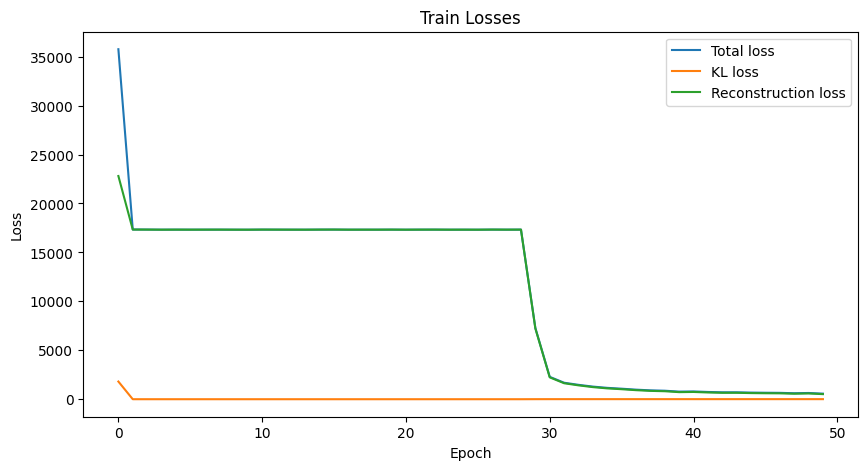

In [30]:
plot_losses('Train Losses', control_train_losses_8, control_train_kl_losses_8, control_train_recon_losses_8)

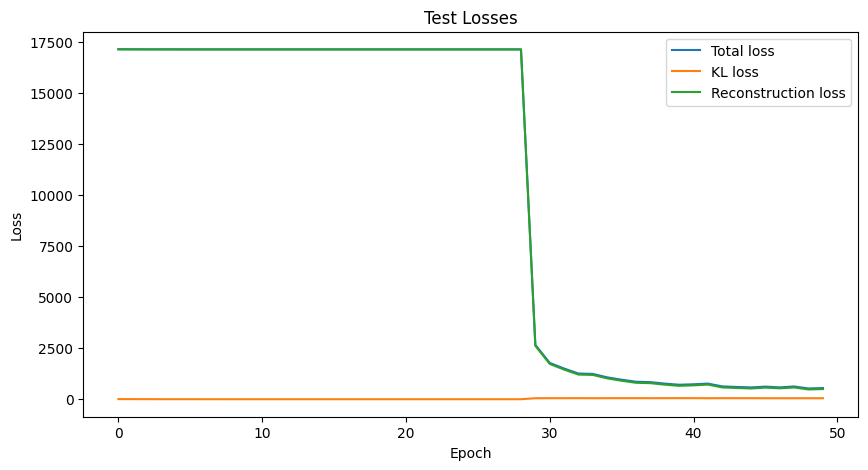

In [31]:
plot_losses('Test Losses', control_test_losses_8, control_test_kl_losses_8, control_test_recon_losses_8)

In [32]:
control_model_14 = VAE(latent_dim=LATENT_DIM).to(device)
control_optimizer_14 = optim.Adam(control_model_14.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))
control_train_losses_14, control_train_kl_losses_14, control_train_recon_losses_14, control_test_losses_14, control_test_kl_losses_14, control_test_recon_losses_14 = train_CVAE(control_model_14, control_optimizer_14, train_dataloader, test_dataloader, epochs=NUM_EPOCHS, setpoint=14.0/BATCH_SIZE)


Epoch 1/50


100%|██████████| 129/129 [00:03<00:00, 38.63it/s]


Train loss: 28815.9699, KL loss: 2.3262, Reconstruciton loss: 244.6220


100%|██████████| 14/14 [00:00<00:00, 52.30it/s]


Test loss: 17141.5117, KL loss: 0.0233, Reconstruciton loss: 171.3918
Epoch 2/50


100%|██████████| 129/129 [00:03<00:00, 39.03it/s]


Train loss: 17325.9854, KL loss: 0.0013, Reconstruciton loss: 173.2327


100%|██████████| 14/14 [00:00<00:00, 53.37it/s]


Test loss: 17140.3216, KL loss: 0.0278, Reconstruciton loss: 171.3755
Epoch 3/50


100%|██████████| 129/129 [00:03<00:00, 38.63it/s]


Train loss: 17328.3413, KL loss: 0.0012, Reconstruciton loss: 173.2577


100%|██████████| 14/14 [00:00<00:00, 54.23it/s]


Test loss: 17139.6204, KL loss: 0.0226, Reconstruciton loss: 171.3736
Epoch 4/50


100%|██████████| 129/129 [00:03<00:00, 37.78it/s]


Train loss: 17327.8036, KL loss: 0.0009, Reconstruciton loss: 173.2588


100%|██████████| 14/14 [00:00<00:00, 52.28it/s]


Test loss: 17138.9746, KL loss: 0.0154, Reconstruciton loss: 171.3743
Epoch 5/50


100%|██████████| 129/129 [00:03<00:00, 38.49it/s]


Train loss: 17328.4345, KL loss: 0.0006, Reconstruciton loss: 173.2721


100%|██████████| 14/14 [00:00<00:00, 51.76it/s]


Test loss: 17138.1020, KL loss: 0.0093, Reconstruciton loss: 171.3717
Epoch 6/50


100%|██████████| 129/129 [00:03<00:00, 38.44it/s]


Train loss: 17321.5032, KL loss: 0.0003, Reconstruciton loss: 173.2081


100%|██████████| 14/14 [00:00<00:00, 52.93it/s]


Test loss: 17137.5506, KL loss: 0.0045, Reconstruciton loss: 171.3710
Epoch 7/50


100%|██████████| 129/129 [00:03<00:00, 38.25it/s]


Train loss: 17319.6796, KL loss: 0.0001, Reconstruciton loss: 173.1944


100%|██████████| 14/14 [00:00<00:00, 53.68it/s]


Test loss: 17137.1251, KL loss: 0.0007, Reconstruciton loss: 171.3705
Epoch 8/50


100%|██████████| 129/129 [00:03<00:00, 38.99it/s]


Train loss: 17326.2285, KL loss: 0.0000, Reconstruciton loss: 173.2620


100%|██████████| 14/14 [00:00<00:00, 53.00it/s]


Test loss: 17137.0534, KL loss: 0.0001, Reconstruciton loss: 171.3704
Epoch 9/50


100%|██████████| 129/129 [00:03<00:00, 38.58it/s]


Train loss: 17324.1497, KL loss: 0.0000, Reconstruciton loss: 173.2415


100%|██████████| 14/14 [00:00<00:00, 52.59it/s]


Test loss: 17137.0414, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 10/50


100%|██████████| 129/129 [00:03<00:00, 38.57it/s]


Train loss: 17328.9129, KL loss: 0.0000, Reconstruciton loss: 173.2891


100%|██████████| 14/14 [00:00<00:00, 50.75it/s]


Test loss: 17137.0394, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 11/50


100%|██████████| 129/129 [00:03<00:00, 38.49it/s]


Train loss: 17321.9617, KL loss: 0.0000, Reconstruciton loss: 173.2196


100%|██████████| 14/14 [00:00<00:00, 51.12it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 12/50


100%|██████████| 129/129 [00:03<00:00, 38.55it/s]


Train loss: 17324.0113, KL loss: 0.0000, Reconstruciton loss: 173.2401


100%|██████████| 14/14 [00:00<00:00, 52.91it/s]


Test loss: 17137.0390, KL loss: 0.0000, Reconstruciton loss: 171.3704
Epoch 13/50


100%|██████████| 129/129 [00:03<00:00, 37.63it/s]


Train loss: 14906.7511, KL loss: 0.0112, Reconstruciton loss: 148.8324


100%|██████████| 14/14 [00:00<00:00, 51.80it/s]


Test loss: 8164.7518, KL loss: 0.8574, Reconstruciton loss: 80.7902
Epoch 14/50


100%|██████████| 129/129 [00:03<00:00, 38.70it/s]


Train loss: 4830.1231, KL loss: 0.0479, Reconstruciton loss: 47.3493


100%|██████████| 14/14 [00:00<00:00, 53.27it/s]


Test loss: 3012.8304, KL loss: 0.8889, Reconstruciton loss: 29.2394
Epoch 15/50


100%|██████████| 129/129 [00:03<00:00, 38.91it/s]


Train loss: 2742.9006, KL loss: 0.0400, Reconstruciton loss: 26.6387


100%|██████████| 14/14 [00:00<00:00, 54.43it/s]


Test loss: 2499.5486, KL loss: 0.7378, Reconstruciton loss: 24.2577
Epoch 16/50


100%|██████████| 129/129 [00:03<00:00, 38.92it/s]


Train loss: 2235.1406, KL loss: 0.0372, Reconstruciton loss: 21.6226


100%|██████████| 14/14 [00:00<00:00, 53.87it/s]


Test loss: 2141.4358, KL loss: 0.6557, Reconstruciton loss: 20.7587
Epoch 17/50


100%|██████████| 129/129 [00:03<00:00, 38.78it/s]


Train loss: 1838.9708, KL loss: 0.0368, Reconstruciton loss: 17.6775


100%|██████████| 14/14 [00:00<00:00, 53.10it/s]


Test loss: 1766.8565, KL loss: 0.6520, Reconstruciton loss: 17.0166
Epoch 18/50


100%|██████████| 129/129 [00:03<00:00, 38.50it/s]


Train loss: 1613.5703, KL loss: 0.0359, Reconstruciton loss: 15.4485


100%|██████████| 14/14 [00:00<00:00, 52.24it/s]


Test loss: 1641.6222, KL loss: 0.6469, Reconstruciton loss: 15.7693
Epoch 19/50


100%|██████████| 129/129 [00:03<00:00, 38.69it/s]


Train loss: 1462.2882, KL loss: 0.0354, Reconstruciton loss: 13.9511


100%|██████████| 14/14 [00:00<00:00, 51.33it/s]


Test loss: 1330.5296, KL loss: 0.6586, Reconstruciton loss: 12.6467
Epoch 20/50


100%|██████████| 129/129 [00:03<00:00, 38.52it/s]


Train loss: 1357.3161, KL loss: 0.0348, Reconstruciton loss: 12.9200


100%|██████████| 14/14 [00:00<00:00, 53.41it/s]


Test loss: 1426.8143, KL loss: 0.6215, Reconstruciton loss: 13.6467
Epoch 21/50


100%|██████████| 129/129 [00:03<00:00, 38.41it/s]


Train loss: 1319.9716, KL loss: 0.0335, Reconstruciton loss: 12.5756


100%|██████████| 14/14 [00:00<00:00, 50.65it/s]


Test loss: 1134.9698, KL loss: 0.6322, Reconstruciton loss: 10.7175
Epoch 22/50


100%|██████████| 129/129 [00:03<00:00, 37.58it/s]


Train loss: 1173.7325, KL loss: 0.0346, Reconstruciton loss: 11.0993


100%|██████████| 14/14 [00:00<00:00, 52.24it/s]


Test loss: 1114.4504, KL loss: 0.6370, Reconstruciton loss: 10.5075
Epoch 23/50


100%|██████████| 129/129 [00:03<00:00, 38.15it/s]


Train loss: 1142.7565, KL loss: 0.0335, Reconstruciton loss: 10.8151


100%|██████████| 14/14 [00:00<00:00, 53.98it/s]


Test loss: 969.2823, KL loss: 0.6089, Reconstruciton loss: 9.0839
Epoch 24/50


100%|██████████| 129/129 [00:03<00:00, 38.83it/s]


Train loss: 1066.3008, KL loss: 0.0340, Reconstruciton loss: 10.0465


100%|██████████| 14/14 [00:00<00:00, 52.14it/s]


Test loss: 996.7811, KL loss: 0.5921, Reconstruciton loss: 9.3757
Epoch 25/50


100%|██████████| 129/129 [00:03<00:00, 38.48it/s]


Train loss: 1020.5835, KL loss: 0.0336, Reconstruciton loss: 9.6028


100%|██████████| 14/14 [00:00<00:00, 51.31it/s]


Test loss: 949.1583, KL loss: 0.5894, Reconstruciton loss: 8.9022
Epoch 26/50


100%|██████████| 129/129 [00:03<00:00, 38.36it/s]


Train loss: 967.3429, KL loss: 0.0337, Reconstruciton loss: 9.0721


100%|██████████| 14/14 [00:00<00:00, 51.42it/s]


Test loss: 888.5195, KL loss: 0.5817, Reconstruciton loss: 8.3035
Epoch 27/50


100%|██████████| 129/129 [00:03<00:00, 38.44it/s]


Train loss: 919.1258, KL loss: 0.0337, Reconstruciton loss: 8.5966


100%|██████████| 14/14 [00:00<00:00, 52.33it/s]


Test loss: 836.0032, KL loss: 0.5856, Reconstruciton loss: 7.7744
Epoch 28/50


100%|██████████| 129/129 [00:03<00:00, 38.84it/s]


Train loss: 921.3955, KL loss: 0.0329, Reconstruciton loss: 8.6373


100%|██████████| 14/14 [00:00<00:00, 49.75it/s]


Test loss: 801.3933, KL loss: 0.5601, Reconstruciton loss: 7.4538
Epoch 29/50


100%|██████████| 129/129 [00:03<00:00, 38.47it/s]


Train loss: 812.3083, KL loss: 0.0341, Reconstruciton loss: 7.5296


100%|██████████| 14/14 [00:00<00:00, 51.88it/s]


Test loss: 812.7414, KL loss: 0.5844, Reconstruciton loss: 7.5430
Epoch 30/50


100%|██████████| 129/129 [00:03<00:00, 37.74it/s]


Train loss: 864.3724, KL loss: 0.0329, Reconstruciton loss: 8.0753


100%|██████████| 14/14 [00:00<00:00, 51.67it/s]


Test loss: 807.0287, KL loss: 0.5703, Reconstruciton loss: 7.4999
Epoch 31/50


100%|██████████| 129/129 [00:03<00:00, 38.63it/s]


Train loss: 860.3284, KL loss: 0.0329, Reconstruciton loss: 8.0402


100%|██████████| 14/14 [00:00<00:00, 53.10it/s]


Test loss: 819.9889, KL loss: 0.5167, Reconstruciton loss: 7.6832
Epoch 32/50


100%|██████████| 129/129 [00:03<00:00, 38.86it/s]


Train loss: 799.8304, KL loss: 0.0330, Reconstruciton loss: 7.4376


100%|██████████| 14/14 [00:00<00:00, 53.84it/s]


Test loss: 820.6978, KL loss: 0.5581, Reconstruciton loss: 7.6489
Epoch 33/50


100%|██████████| 129/129 [00:03<00:00, 39.15it/s]


Train loss: 807.4595, KL loss: 0.0327, Reconstruciton loss: 7.5231


100%|██████████| 14/14 [00:00<00:00, 53.29it/s]


Test loss: 664.4430, KL loss: 0.5535, Reconstruciton loss: 6.0909
Epoch 34/50


100%|██████████| 129/129 [00:03<00:00, 38.63it/s]


Train loss: 728.3570, KL loss: 0.0338, Reconstruciton loss: 6.7183


100%|██████████| 14/14 [00:00<00:00, 52.94it/s]


Test loss: 743.4534, KL loss: 0.5304, Reconstruciton loss: 6.9041
Epoch 35/50


100%|██████████| 129/129 [00:03<00:00, 39.05it/s]


Train loss: 818.7446, KL loss: 0.0322, Reconstruciton loss: 7.6521


100%|██████████| 14/14 [00:00<00:00, 53.28it/s]


Test loss: 638.0344, KL loss: 0.5367, Reconstruciton loss: 5.8436
Epoch 36/50


100%|██████████| 129/129 [00:03<00:00, 38.85it/s]


Train loss: 693.7547, KL loss: 0.0340, Reconstruciton loss: 6.3770


100%|██████████| 14/14 [00:00<00:00, 53.07it/s]


Test loss: 811.3183, KL loss: 0.5471, Reconstruciton loss: 7.5661
Epoch 37/50


100%|██████████| 129/129 [00:03<00:00, 38.64it/s]


Train loss: 704.4328, KL loss: 0.0332, Reconstruciton loss: 6.4999


100%|██████████| 14/14 [00:00<00:00, 54.75it/s]


Test loss: 673.0995, KL loss: 0.5224, Reconstruciton loss: 6.2086
Epoch 38/50


100%|██████████| 129/129 [00:03<00:00, 38.76it/s]


Train loss: 705.9966, KL loss: 0.0334, Reconstruciton loss: 6.5156


100%|██████████| 14/14 [00:00<00:00, 52.65it/s]


Test loss: 764.6173, KL loss: 0.5159, Reconstruciton loss: 7.1302
Epoch 39/50


100%|██████████| 129/129 [00:03<00:00, 38.11it/s]


Train loss: 672.3649, KL loss: 0.0333, Reconstruciton loss: 6.1852


100%|██████████| 14/14 [00:00<00:00, 52.57it/s]


Test loss: 682.7633, KL loss: 0.5236, Reconstruciton loss: 6.3040
Epoch 40/50


100%|██████████| 129/129 [00:03<00:00, 38.38it/s]


Train loss: 644.4050, KL loss: 0.0334, Reconstruciton loss: 5.9080


100%|██████████| 14/14 [00:00<00:00, 53.42it/s]


Test loss: 661.1149, KL loss: 0.5279, Reconstruciton loss: 6.0833
Epoch 41/50


100%|██████████| 129/129 [00:03<00:00, 39.15it/s]


Train loss: 675.3205, KL loss: 0.0330, Reconstruciton loss: 6.2260


100%|██████████| 14/14 [00:00<00:00, 52.25it/s]


Test loss: 668.7581, KL loss: 0.5049, Reconstruciton loss: 6.1827
Epoch 42/50


100%|██████████| 129/129 [00:03<00:00, 38.90it/s]


Train loss: 631.1797, KL loss: 0.0332, Reconstruciton loss: 5.7859


100%|██████████| 14/14 [00:00<00:00, 52.79it/s]


Test loss: 614.0462, KL loss: 0.4965, Reconstruciton loss: 5.6440
Epoch 43/50


100%|██████████| 129/129 [00:03<00:00, 38.64it/s]


Train loss: 619.2705, KL loss: 0.0335, Reconstruciton loss: 5.6654


100%|██████████| 14/14 [00:00<00:00, 51.60it/s]


Test loss: 580.2752, KL loss: 0.5155, Reconstruciton loss: 5.2873
Epoch 44/50


100%|██████████| 129/129 [00:03<00:00, 38.28it/s]


Train loss: 610.9880, KL loss: 0.0337, Reconstruciton loss: 5.5832


100%|██████████| 14/14 [00:00<00:00, 53.15it/s]


Test loss: 529.3051, KL loss: 0.5197, Reconstruciton loss: 4.7734
Epoch 45/50


100%|██████████| 129/129 [00:03<00:00, 38.38it/s]


Train loss: 576.0323, KL loss: 0.0338, Reconstruciton loss: 5.2346


100%|██████████| 14/14 [00:00<00:00, 47.87it/s]


Test loss: 566.8413, KL loss: 0.5133, Reconstruciton loss: 5.1551
Epoch 46/50


100%|██████████| 129/129 [00:03<00:00, 38.95it/s]


Train loss: 575.9395, KL loss: 0.0340, Reconstruciton loss: 5.2345


100%|██████████| 14/14 [00:00<00:00, 51.87it/s]


Test loss: 681.1617, KL loss: 0.5152, Reconstruciton loss: 6.2965
Epoch 47/50


100%|██████████| 129/129 [00:03<00:00, 37.48it/s]


Train loss: 608.8225, KL loss: 0.0334, Reconstruciton loss: 5.5759


100%|██████████| 14/14 [00:00<00:00, 53.69it/s]


Test loss: 670.8171, KL loss: 0.5077, Reconstruciton loss: 6.2005
Epoch 48/50


100%|██████████| 129/129 [00:03<00:00, 38.49it/s]


Train loss: 560.2911, KL loss: 0.0338, Reconstruciton loss: 5.0876


100%|██████████| 14/14 [00:00<00:00, 53.70it/s]


Test loss: 586.8594, KL loss: 0.4948, Reconstruciton loss: 5.3738
Epoch 49/50


100%|██████████| 129/129 [00:03<00:00, 39.43it/s]


Train loss: 577.6305, KL loss: 0.0334, Reconstruciton loss: 5.2697


100%|██████████| 14/14 [00:00<00:00, 54.21it/s]


Test loss: 561.6466, KL loss: 0.5190, Reconstruciton loss: 5.0974
Epoch 50/50


100%|██████████| 129/129 [00:03<00:00, 38.98it/s]


Train loss: 569.8011, KL loss: 0.0336, Reconstruciton loss: 5.1910


100%|██████████| 14/14 [00:00<00:00, 54.08it/s]

Test loss: 514.4406, KL loss: 0.5027, Reconstruciton loss: 4.6417


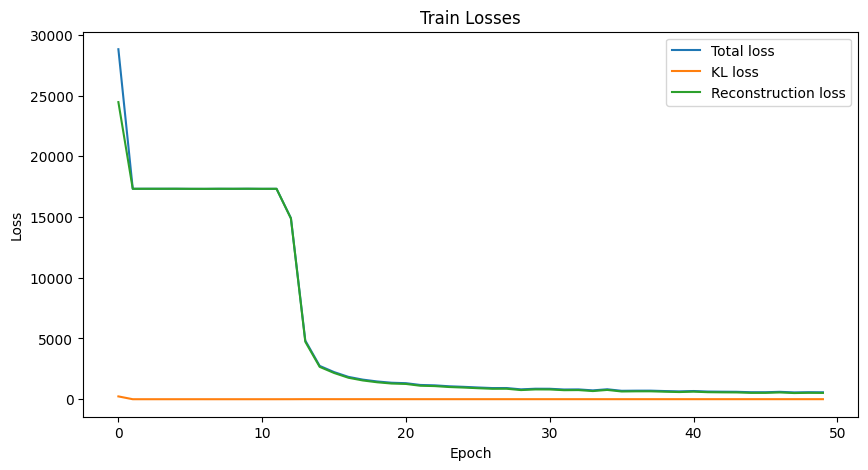

In [33]:
plot_losses('Train Losses', control_train_losses_14, control_train_kl_losses_14, control_train_recon_losses_14)

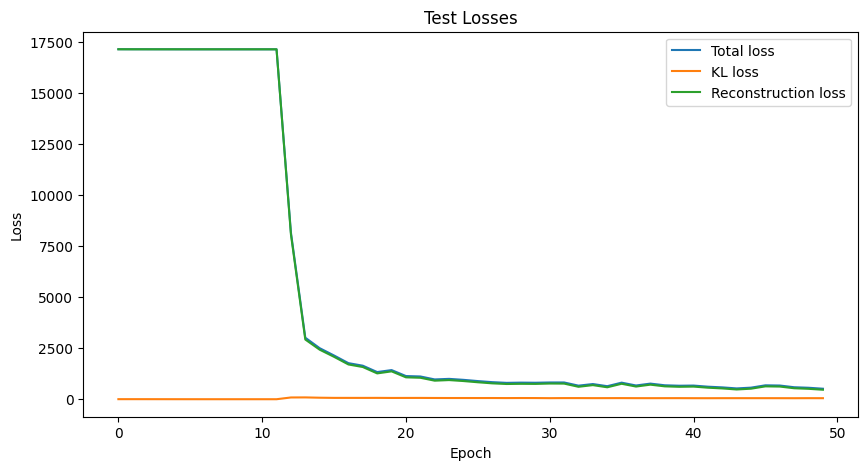

In [34]:
plot_losses('Test Losses', control_test_losses_14, control_test_kl_losses_14, control_test_recon_losses_14)

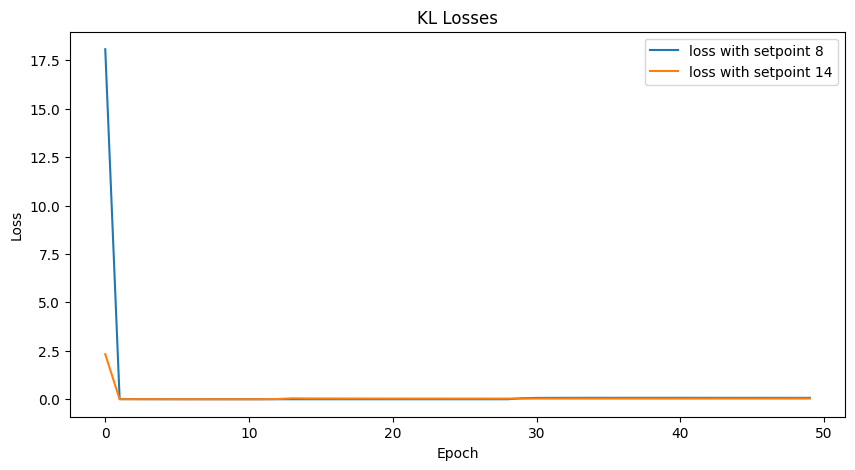

In [35]:
plot_losses_with_setpoint('KL Losses', 8, 14, control_train_kl_losses_8, control_train_kl_losses_14)

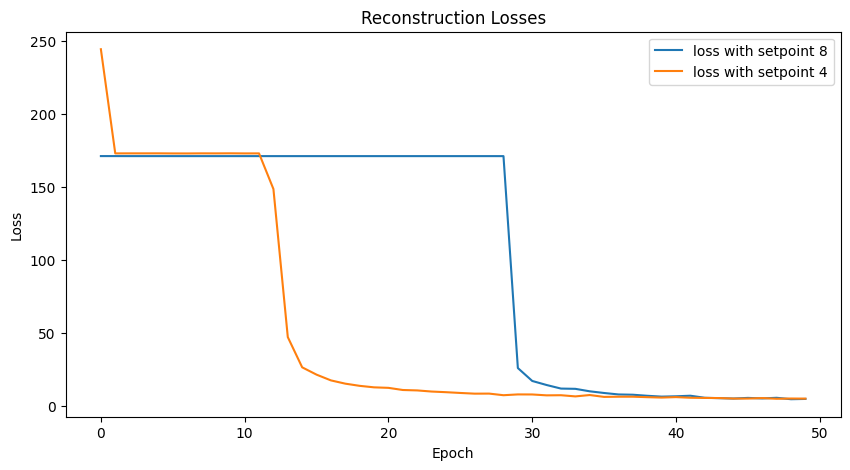

In [36]:
plot_losses_with_setpoint('Reconstruction Losses', 8, 4, control_test_recon_losses_8, control_train_recon_losses_14)

In [37]:
CVAE8_GENERATED_DIR = 'cvae8_generated_samples'

os.makedirs(CVAE8_GENERATED_DIR, exist_ok=True)

control_model_8.eval()
with torch.no_grad():
    for i, batch in enumerate(fid_train_dataloader):
        batch = batch.to(device)
        x_hat, _, _ = control_model_8(batch)
        x_hat = torch.round(x_hat)
        image = x_hat[0][0]
        image = image * 255
        image = image.byte()
        image = transforms.ToPILImage()(image)
        image.save(os.path.join(CVAE8_GENERATED_DIR, f'train_{i}.png'))

    for i, batch in enumerate(fid_test_dataloader):
        batch = batch.to(device)
        x_hat, _, _ = control_model_8(batch)
        x_hat = torch.round(x_hat)
        image = x_hat[0][0]
        image = image * 255
        image = image.byte()
        image = transforms.ToPILImage()(image)
        image.save(os.path.join(CVAE8_GENERATED_DIR, f'test_{i}.png'))

In [38]:
CVAE14_GENERATED_DIR = 'cvae8_generated_samples'

os.makedirs(CVAE14_GENERATED_DIR, exist_ok=True)

control_model_14.eval()
with torch.no_grad():
    for i, batch in enumerate(fid_train_dataloader):
        batch = batch.to(device)
        x_hat, _, _ = control_model_14(batch)
        x_hat = torch.round(x_hat)
        image = x_hat[0][0]
        image = image * 255
        image = image.byte()
        image = transforms.ToPILImage()(image)
        image.save(os.path.join(CVAE14_GENERATED_DIR, f'train_{i}.png'))

    for i, batch in enumerate(fid_test_dataloader):
        batch = batch.to(device)
        x_hat, _, _ = control_model_14(batch)
        x_hat = torch.round(x_hat)
        image = x_hat[0][0]
        image = image * 255
        image = image.byte()
        image = transforms.ToPILImage()(image)
        image.save(os.path.join(CVAE14_GENERATED_DIR, f'test_{i}.png'))

In [39]:
CVAE8_fid_score = fid_score.calculate_fid_given_paths([ORIGINAL_DIR, CVAE8_GENERATED_DIR], batch_size=50, device=device, dims=2048)
print(CVAE8_fid_score)

100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


7.958554652797815


In [40]:
CVAE14_fid_score = fid_score.calculate_fid_given_paths([ORIGINAL_DIR, CVAE14_GENERATED_DIR], batch_size=50, device=device, dims=2048)
print(CVAE14_fid_score)

100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


7.958554652797815
